In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

import pandas as pd

from sequence_logo_helper import dna_letter_at, plot_dna_logo

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Define dataset/experiment name
dataset_name = "optimus5_synth"

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

#Load cached dataframe
e_train = pd.read_csv("otherHalfOfHumanUTRs_UseForBackground.csv")

#one hot encode with optimus encoders 
seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train[:, None, ...]

print("x_train.shape = " + str(x_train.shape))


x_train.shape = (12520, 1, 50, 4)


In [3]:
#Define sequence template

sequence_template = 'N' * 50

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [4]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))


In [5]:
#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()


(3, 1, 50, 4)
Processing example 0...
Total number of predictor calls   = 4822
Average number of predictor calls = 1607.3333333333333
Test sequence 0:


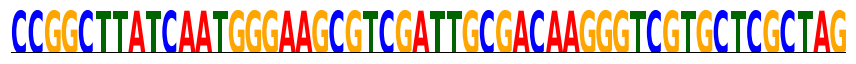

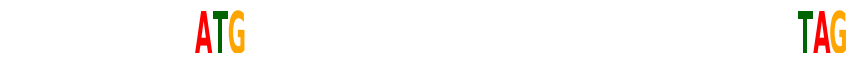

Test sequence 1:


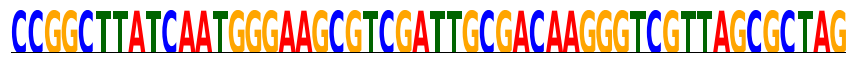

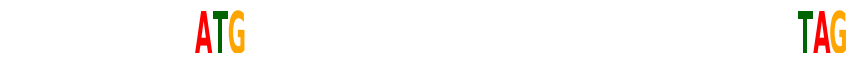

Test sequence 2:


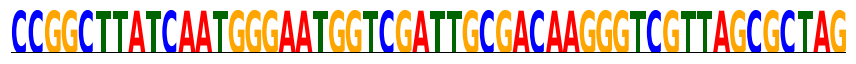

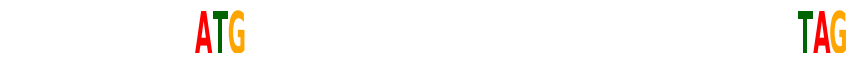

In [7]:
import sis

#Run attribution method

encoder = isol.OneHotEncoder(50)

score_clip = None

allFiles = ["optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_1_start_2_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_2_stop_variable_loc_512.csv",
            "optimus5_synthetic_examples_3.csv"]

for csv_to_open in allFiles :
    
    #Load dataset for benchmarking 
    dataset_name = csv_to_open.replace(".csv", "")
    data_df = pd.read_csv(csv_to_open) #open from scores folder 

    seq_e_test = one_hot_encode(data_df, seq_len=50)
    x_test = seq_e_test[:, None, ...]
    
    print(x_test.shape)
    
    #Plot distribution of (MRL)

    y_pred_test = predictor.predict(x=[x_test[:, 0, ...]], batch_size=32)[:, 0]

     #Run SIS on test set

    dynamic_threshold_scale = 0.8

    n_seqs_to_test = x_test.shape[0]

    importance_scores_test = []

    predictor_calls_test = []

    for data_ix in range(n_seqs_to_test) :

        if data_ix % 100 == 0 :
            print("Processing example " + str(data_ix) + "...")

        is_pos = True if y_pred_test[data_ix] >= 0.0 else False

        threshold = 0.
        if is_pos :
            threshold = dynamic_threshold_scale * y_pred_test[data_ix]
        else :
            threshold = dynamic_threshold_scale * (-y_pred_test[data_ix])

        x_curr = x_test[data_ix, 0, ...]

        bg = x_mean

        seq_mask = np.max(x_test[data_ix, 0, ...], axis=-1, keepdims=True)

        predictor_counter = { 'acc' : 0 }

        def _temp_pred_func(batch, is_pos=is_pos, mask=seq_mask, predictor_counter=predictor_counter) :

            temp_data = np.concatenate([np.expand_dims(np.expand_dims(arr * mask, axis=0), axis=0) for arr in batch], axis=0)

            predictor_counter['acc'] += temp_data.shape[0]

            temp_out = None
            if is_pos :
                temp_out = predictor.predict(x=[temp_data[:, 0, ...]], batch_size=64)[:, 0]
            else :
                temp_out = -predictor.predict(x=[temp_data[:, 0, ...]], batch_size=64)[:, 0]

            return temp_out

        F_PRED = lambda batch: _temp_pred_func(batch)

        x_fully_masked = np.copy(bg)

        initial_mask = sis.make_empty_boolean_mask_broadcast_over_axis(x_curr.shape, 1)

        collection = sis.sis_collection(F_PRED, threshold, x_curr, x_fully_masked, initial_mask=initial_mask)

        importance_scores_test_curr = np.expand_dims(np.expand_dims(np.zeros(x_curr.shape), axis=0), axis=0)
        if collection[0].sis.shape[0] > 0 :
            imp_index = collection[0].sis[:, 0].tolist()

            importance_scores_test_curr[0, 0, imp_index, :] = 1.
            importance_scores_test_curr[0, 0, ...] = importance_scores_test_curr[0, 0, ...] * x_curr

        importance_scores_test.append(importance_scores_test_curr)

        predictor_calls_test.append(predictor_counter['acc'])

    importance_scores_test = np.concatenate(importance_scores_test, axis=0)

    predictor_calls_test = np.array(predictor_calls_test)

    #Print predictor call statistics

    print("Total number of predictor calls   = " + str(np.sum(predictor_calls_test)))
    print("Average number of predictor calls = " + str(np.mean(predictor_calls_test)))
    
    for plot_i in range(0, 3) :

        print("Test sequence " + str(plot_i) + ":")

        plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, plot_sequence_template=True, figsize=(12, 1), plot_start=0, plot_end=50)
        plot_importance_scores(importance_scores_test[plot_i, 0, :, :].T, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=50)

    #Save predicted importance scores

    model_name = "sufficient_input_subsets_" + dataset_name + "_dynamic_thresh_08_mean"

    np.save(model_name + "_importance_scores_test", importance_scores_test)
